## Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import graphviz
from scipy.stats import chi2_contingency
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_curve,auc
import seaborn as sns

## Read the data

In [ ]:
df=pd.read_excel(r"/content/drive/MyDrive/DAL dataset/Assignment 5/car_evaluation.xlsx",header=None)
df.head()

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [ ]:
df=df.set_axis(['Buying price','Maintenance cost','Number of doors','Number of persons','lug_boot','safety','decision'],axis='columns')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Buying price       1728 non-null   object
 1   Maintenance cost   1728 non-null   object
 2   Number of doors    1728 non-null   object
 3   Number of persons  1728 non-null   object
 4   lug_boot           1728 non-null   object
 5   safety             1728 non-null   object
 6   decision           1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [ ]:
df=df.astype(str)
for cols in df.columns:
  print(df[cols].value_counts())

vhigh    432
high     432
med      432
low      432
Name: Buying price, dtype: int64
vhigh    432
high     432
med      432
low      432
Name: Maintenance cost, dtype: int64
2        432
3        432
4        432
5more    432
Name: Number of doors, dtype: int64
2       576
4       576
more    576
Name: Number of persons, dtype: int64
small    576
med      576
big      576
Name: lug_boot, dtype: int64
low     576
med     576
high    576
Name: safety, dtype: int64
unacc    1210
acc       384
good       69
vgood      65
Name: decision, dtype: int64


**So there is no missing value in object type**

## Preliminary visualization

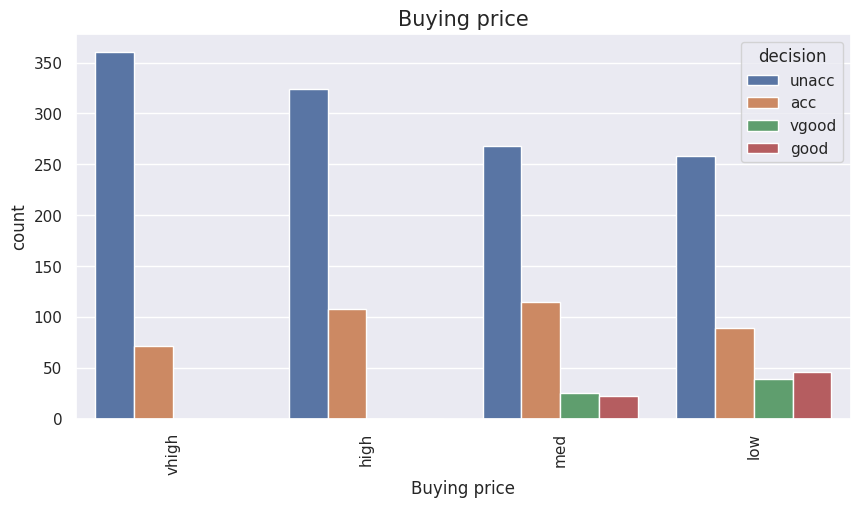

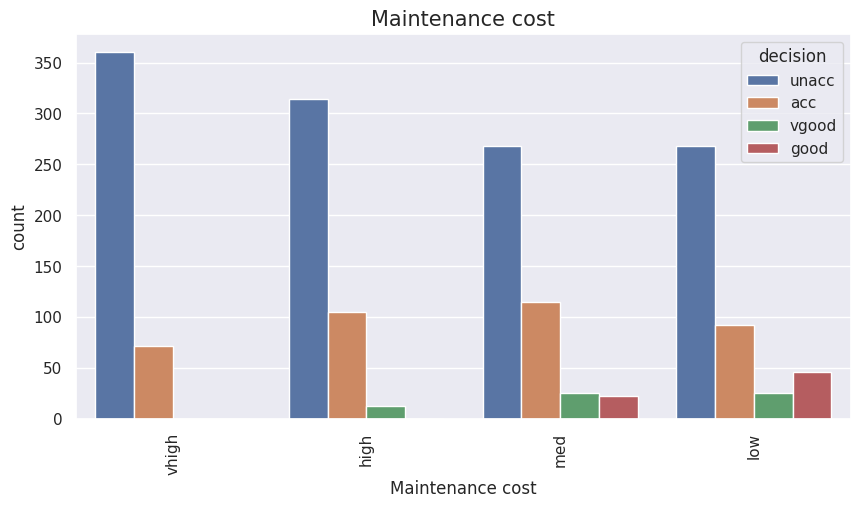

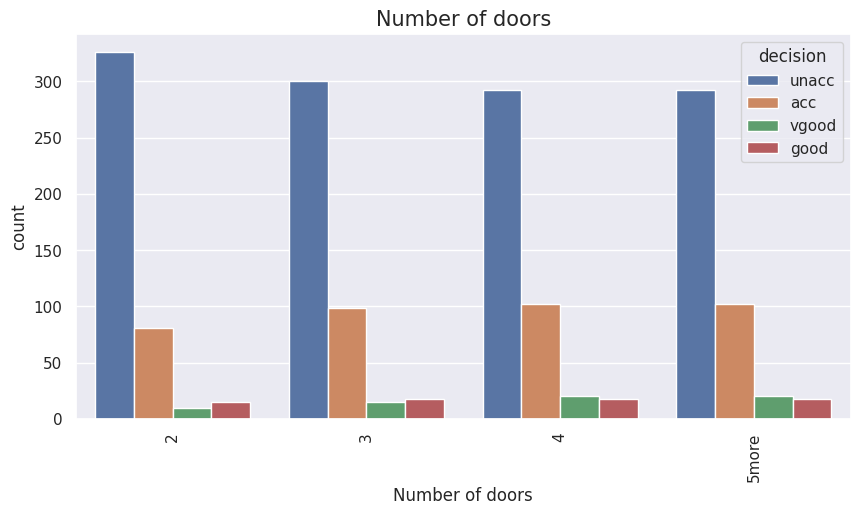

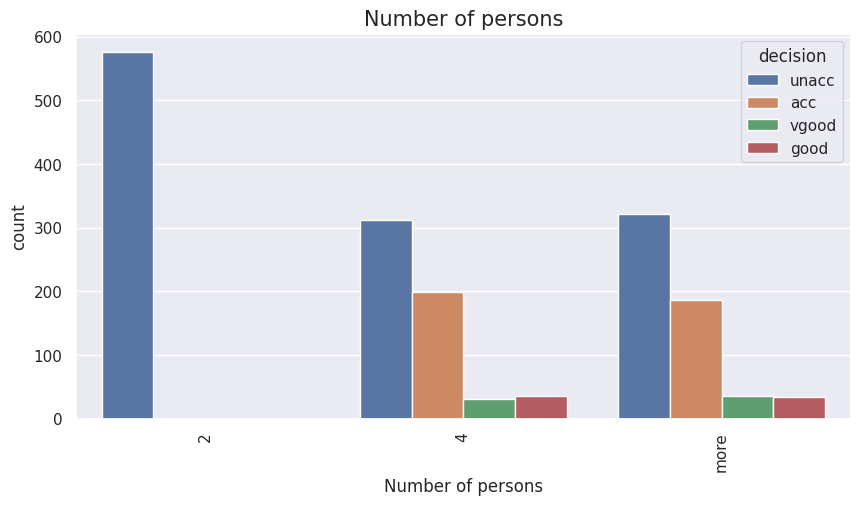

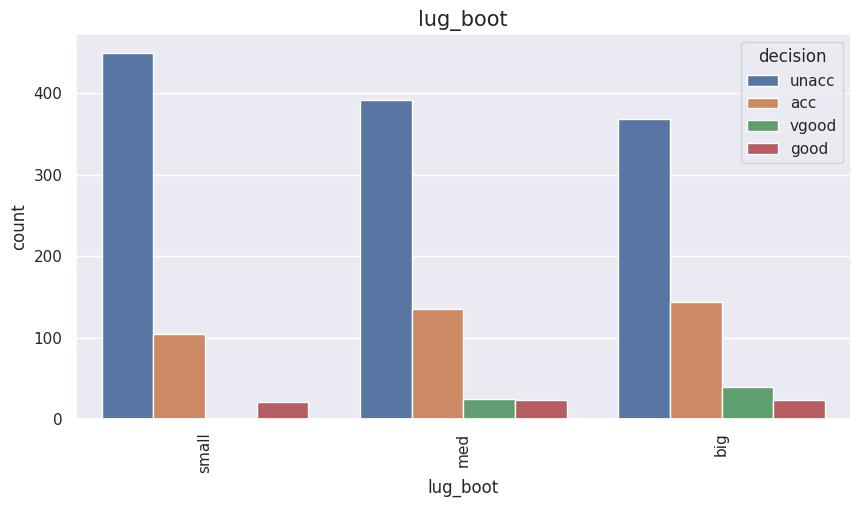

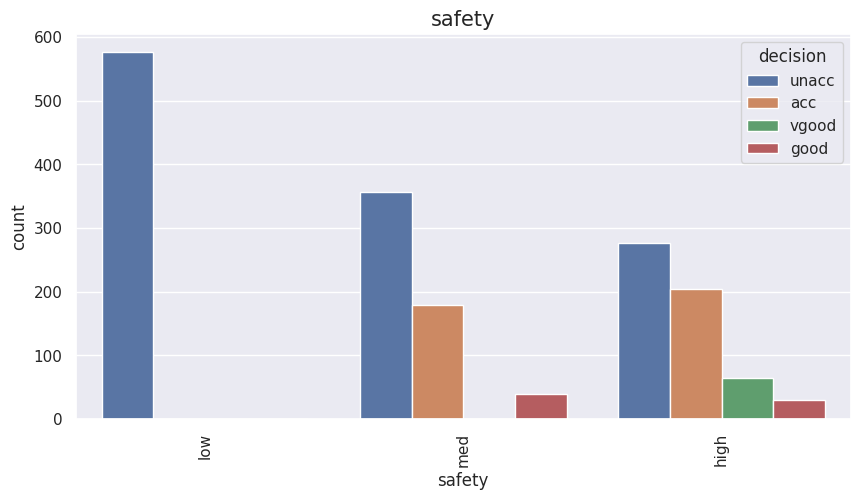

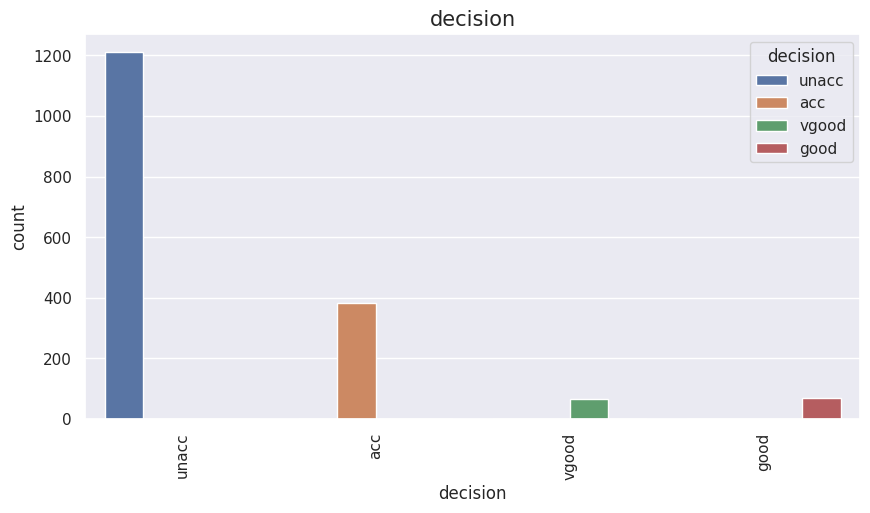

In [ ]:
sns.set()
#check the bar plots for categorical features
for cat in df.columns:
  plt.figure(figsize=(10,5))
  sns.countplot(x=cat,data=df,hue='decision')
  plt.title(cat,fontsize=15)
  plt.xticks(rotation=90)
  plt.savefig(f"{cat}.png",bbox_inches = 'tight')
  plt.show()

## Cramer's V for correlation estimation

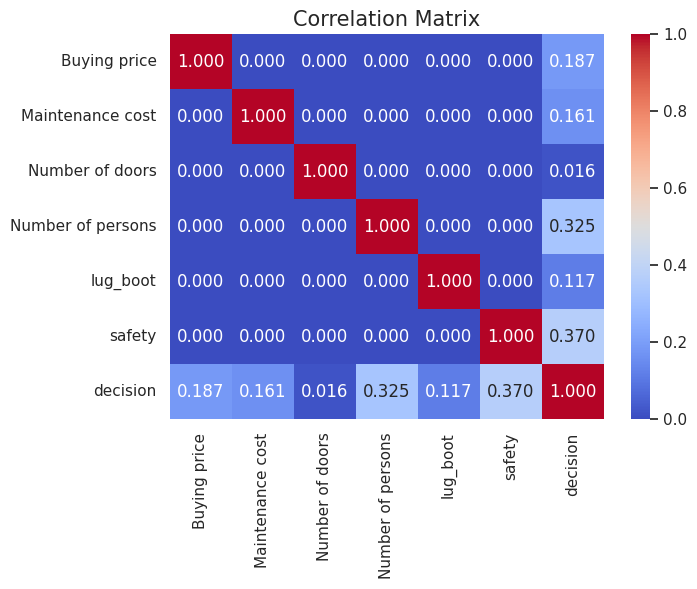

In [ ]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Calculate correlation matrix for all features (including numerical and categorical)
correlation_matrix = pd.DataFrame(index=df.columns, columns=df.columns, dtype=np.float64)

for feature1 in df.columns:
    for feature2 in df.columns:
        if df[feature1].dtype == 'object' and df[feature2].dtype == 'object':
            # Calculate Cramér's V for two categorical variables
            conf = pd.crosstab(df[feature1], df[feature2])
            correlation_matrix.loc[feature1, feature2] = cramers_v(conf.values)

# Visualize the correlation matrix using Seaborn heatmap
plt.figure(figsize=(7,5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f")
plt.title("Correlation Matrix",fontsize=15)
plt.show()

**Independent features are almost uncorrelated. And the Decision feature is clearly dependent on the other features.**

##Training part

In [ ]:
#drop the target
y=df.pop('decision')
X=copy.deepcopy(df)
#splitting the data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

## Apply gridsearch crossvalidation to get the best hyper parameters

In [ ]:
Clf=RandomForestClassifier()
params={'n_estimators':[10,20,30,50],'min_samples_leaf':[1,2,3,4],'max_features':['sqrt','log2',None],'max_leaf_nodes':[None,10,20,30,40,50]}
G=GridSearchCV(Clf,param_grid=params,n_jobs=-1,cv=10,verbose=2)
X_num_train=X_train.apply(LabelEncoder().fit_transform)
G.fit(X_num_train,y_train)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [None, 10, 20, 30, 40, 50],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'n_estimators': [10, 20, 30, 50]},
             verbose=2)

In [ ]:
G.best_params_

{'max_features': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'n_estimators': 30}

In [ ]:
X_num_test=X_test.apply(LabelEncoder().fit_transform)
yhat_test=G.best_estimator_.predict(X_num_test)

##Model Evaluation

In [ ]:
print(classification_report(y_test,yhat_test))

              precision    recall  f1-score   support

         acc       0.97      0.99      0.98        77
        good       1.00      1.00      1.00        14
       unacc       1.00      1.00      1.00       242
       vgood       1.00      0.92      0.96        13

    accuracy                           0.99       346
   macro avg       0.99      0.98      0.98       346
weighted avg       0.99      0.99      0.99       346



## Confusion Matrix

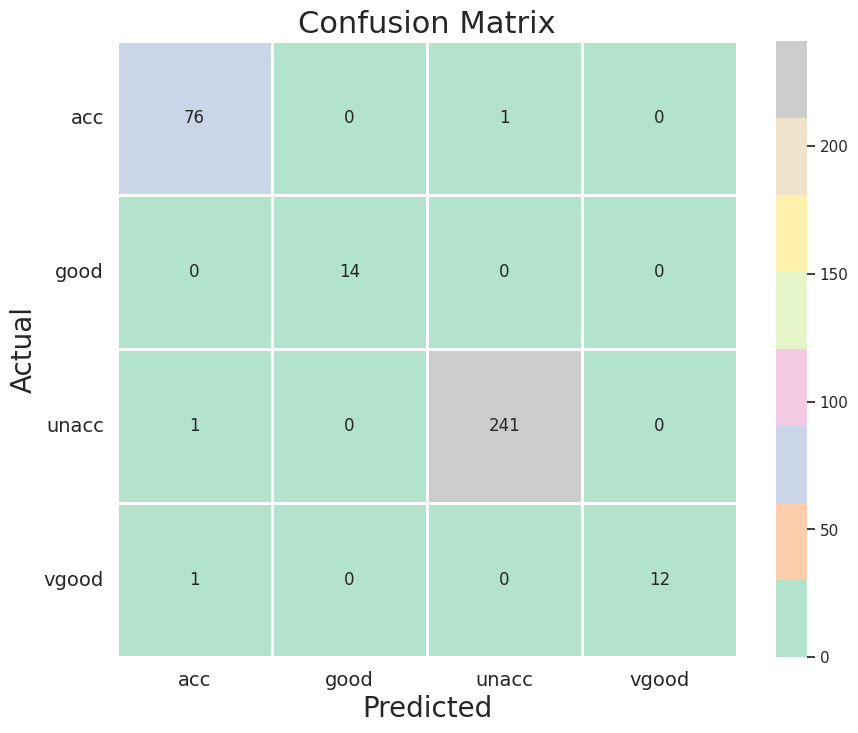

In [ ]:
labels=np.unique(y_test)
CM=confusion_matrix(y_test,yhat_test)
plt.figure(figsize=(10,8))
plt.title("Confusion Matrix",fontsize=22)
sns.heatmap(CM,annot=True,cmap='Pastel2',fmt='0.3g',linewidths=1.0)
plt.yticks(np.arange(len(labels))+0.5,labels,fontsize=14,rotation='horizontal')
plt.xticks(np.arange(len(labels))+0.5,labels,fontsize=14)
plt.xlabel("Predicted",fontsize=20)
plt.ylabel("Actual",fontsize=20)
plt.savefig("Conf.png")
plt.show()

##ROC curve

In [ ]:
oh_test=pd.get_dummies(y_test)
oh_pred=G.best_estimator_.predict_proba(X_num_test)

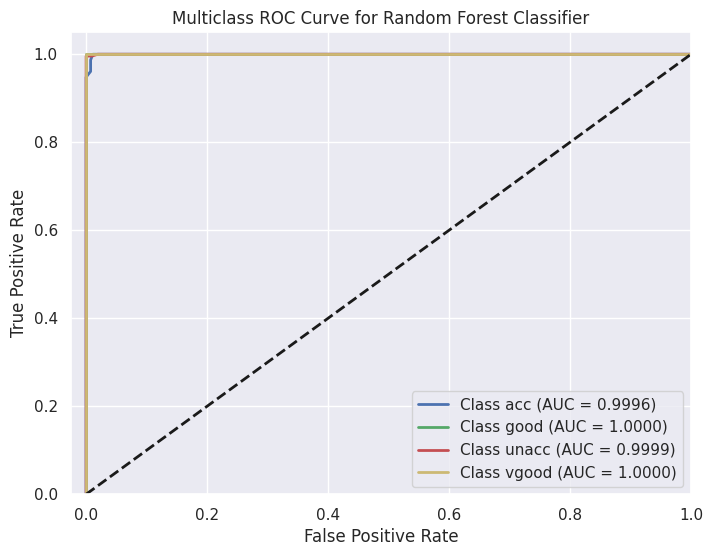

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes=oh_test.columns
for i in range(len(num_classes)):
    fpr[i], tpr[i], _ = roc_curve(oh_test.loc[:, num_classes[i]], oh_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r','y']  # Use appropriate colors based on the number of classes
for k,(i, color) in enumerate(zip(num_classes, colors)):
    plt.plot(fpr[k], tpr[k], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[k]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.025, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve for Random Forest Classifier')
plt.legend(loc='lower right')
plt.savefig("ROC.png")
plt.show()

##Visualization on the test data

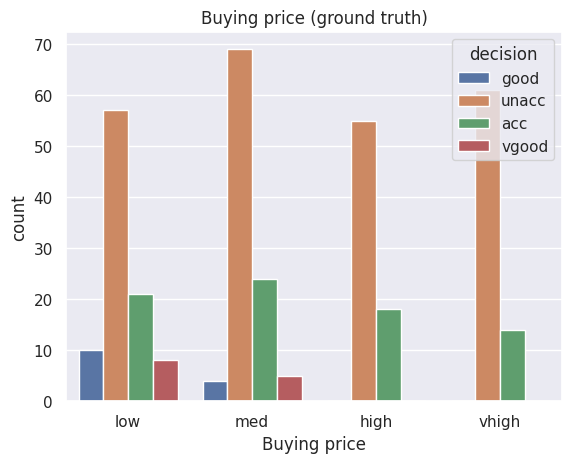

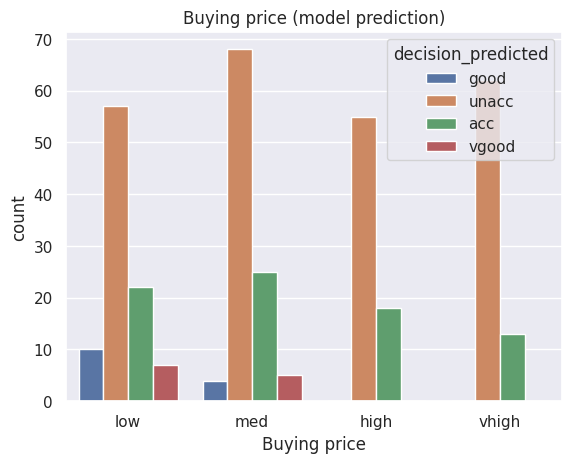

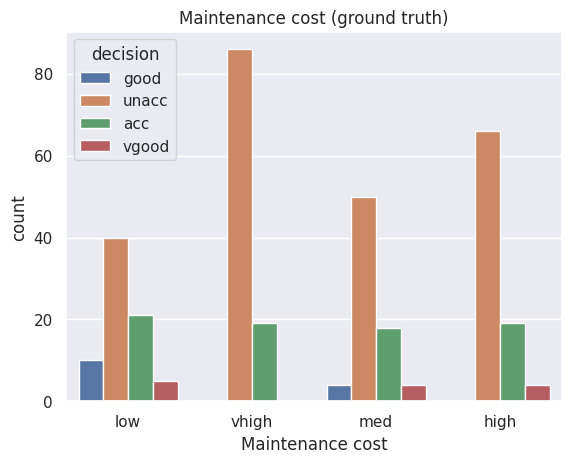

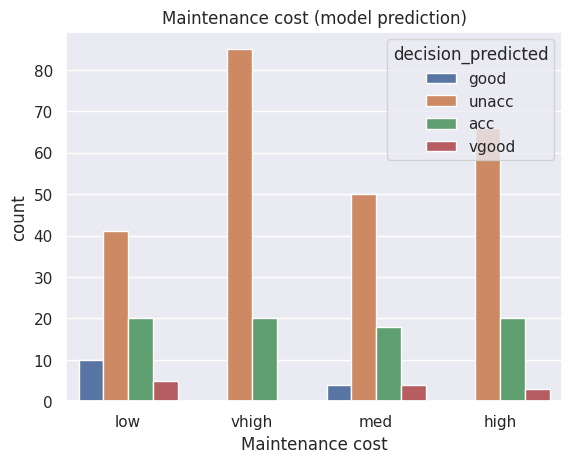

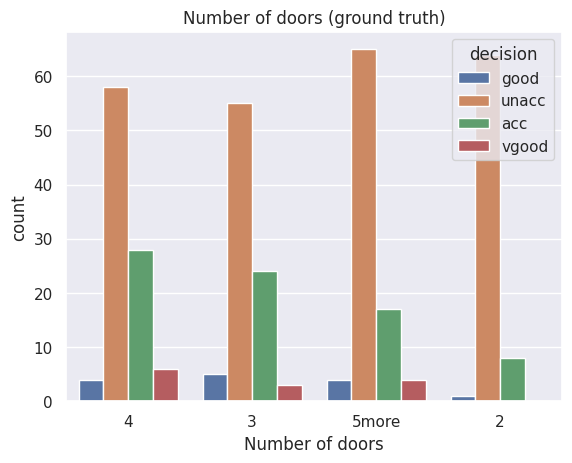

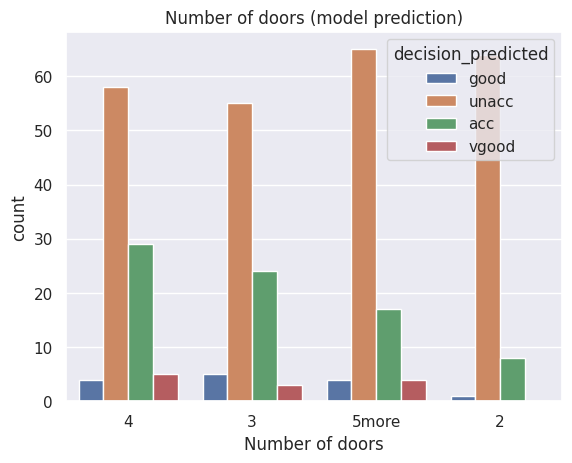

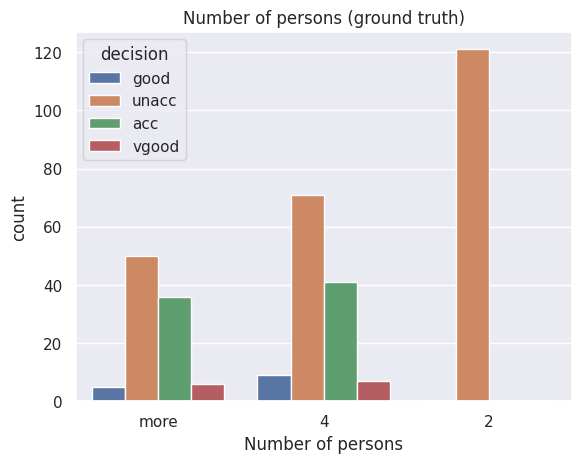

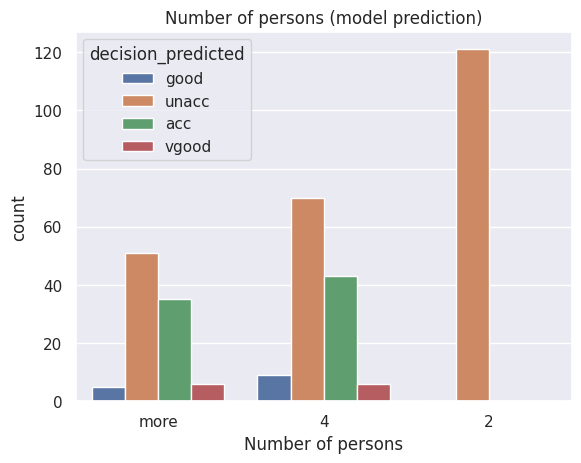

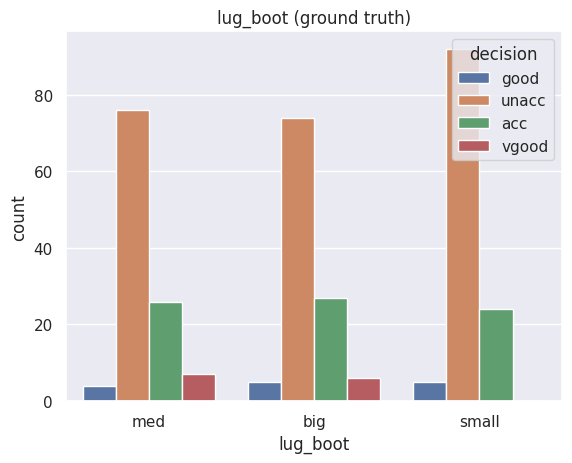

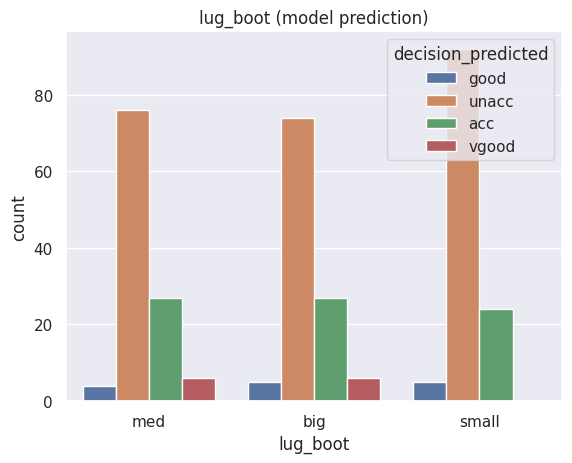

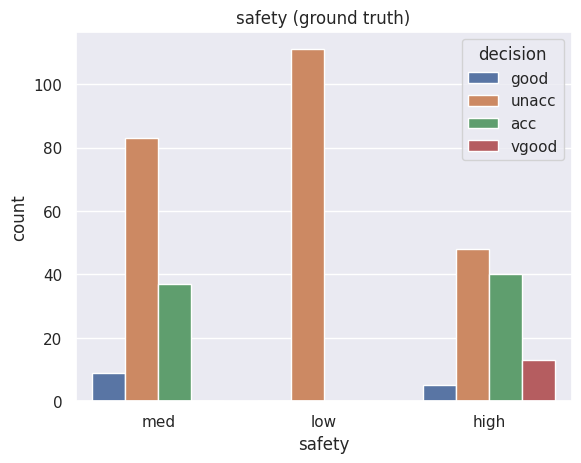

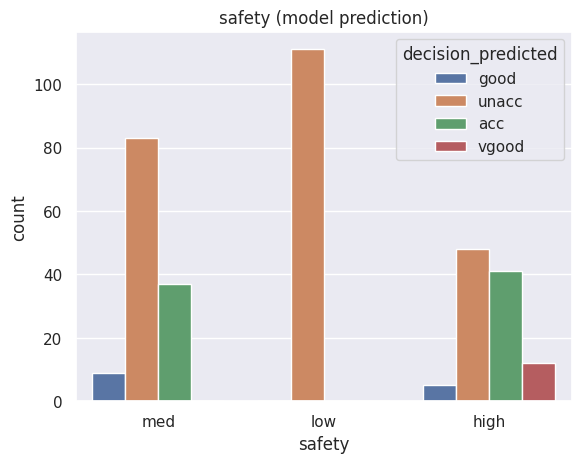

In [ ]:
X_test1=copy.deepcopy(X_test)
X_test2=copy.deepcopy(X_test)
X_test1['decision']=y_test
X_test2['decision_predicted']=yhat_test
cols=['Buying price','Maintenance cost','Number of doors','Number of persons','lug_boot','safety']
for cat in cols:
  plt.title(f"{cat} (ground truth)")
  sns.countplot(x=cat,data=X_test1,hue='decision')
  plt.savefig(f"test_{cat}_tru.png",bbox_inches = 'tight')
  plt.show()
  plt.title(f"{cat} (model prediction)")
  sns.countplot(x=cat,data=X_test2,hue='decision_predicted')
  plt.savefig(f"test_{cat}_pred.png",bbox_inches = 'tight')
  plt.show()

##End of Code